# scRNAseq 的谱聚类

In [54]:
library(dplyr)
library(Seurat)
library(kernlab)
library(CrossClustering)
library(mclust)

In [55]:
# load benchmark dataset: zhengmix8eq
dat0 = readRDS(file = "~/Downloads/scrna2019-master/real_benchmarking/data/Zhengmix8eq/expr.rds")

In [56]:
# 利用表面marker划分出的细胞类别，作为‘金标准’
ID = dat0$phenoid
unique(ID) ## 共有八类

[1] "b.cells"         "naive.cytotoxic" "cd14.monocytes"  "regulatory.t"   
[5] "cd4.t.helper"    "cd56.nk"         "memory.t"        "naive.t"

## 1. Prepare data

In [57]:
# 1. Create Seurate object
dat = CreateSeuratObject(counts = assay(dat0,"counts"), project = "zhengmix8eq")

In [58]:
# 2. Normalization
dat <- NormalizeData(dat, normalization.method = "LogNormalize", scale.factor = 10000)

In [59]:
# 3. Find most variable genes
dat <- FindVariableFeatures(dat, selection.method = "vst", nfeatures = 1000) ## 如果换成nfeatures = 2000，结果会提高到0.74

In [60]:
# 4. Scale data
feat <- dat@assays$RNA@var.features
dat <- ScaleData(dat, features = feat)

Centering and scaling data matrix



## 2. 用R自带的 PCA

In [61]:
pca_out = prcomp(t(dat@assays$RNA@scale.data)) ## 速度稍慢

In [62]:
seu <- CreateSeuratObject(t(pca_out$x)) #只是建一个Seurat object
seu[["pca"]] <- CreateDimReducObject(as.matrix(pca_out$x),key="PC_",assay=DefaultAssay(seu))

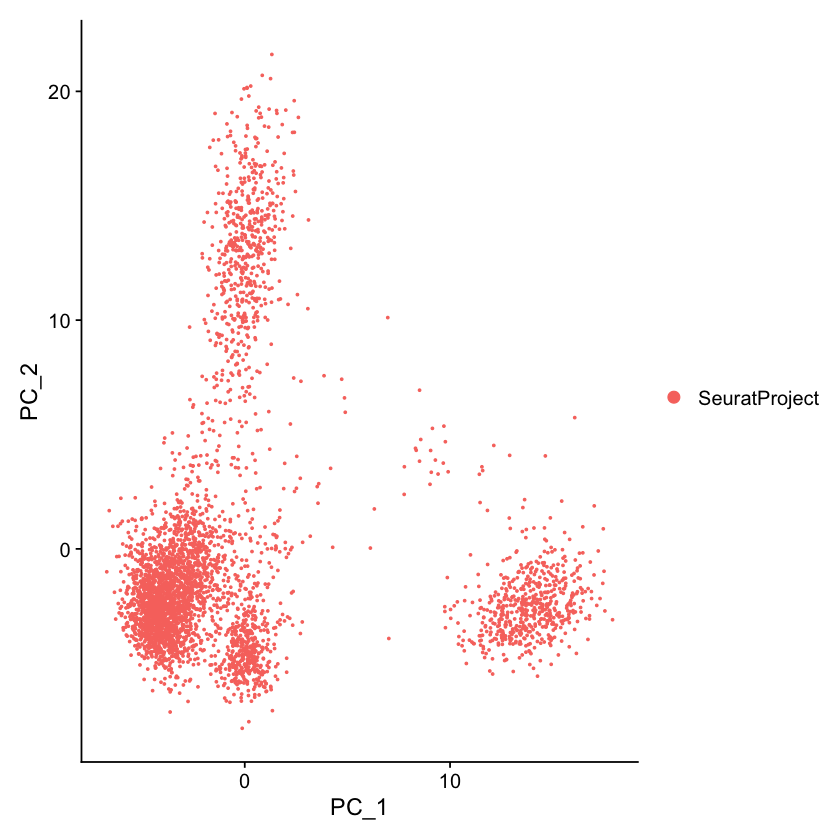

In [63]:
DimPlot(seu, reduction = "pca")

## 3. Spectral clustering

In [64]:
# 3.1 Find nearest neighbors
seu <- FindNeighbors(seu, dims = 1:10)

Computing nearest neighbor graph

Computing SNN



In [65]:
# 3.2 spectral clustering 
seu <- FindClusters(seu, resolution = 0.6)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3994
Number of edges: 142633

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8660
Number of communities: 8
Elapsed time: 0 seconds


In [66]:
# look at the results
table(Idents(seu),ID)

   ID
    b.cells cd14.monocytes cd4.t.helper cd56.nk memory.t naive.cytotoxic
  0       0              6          174       5      460               4
  1       0              0          213       1       16               7
  2       0              1            2     592        0               0
  3       0            559            0       0        0               0
  4     467              2            0       1        0               1
  5       0              0           10       1       24             386
  6       0             32            1       0        0               0
  7      32              0            0       0        0               0
   ID
    naive.t regulatory.t
  0       9          342
  1     472          154
  2       1            0
  3       0            0
  4       1            0
  5      16            2
  6       0            0
  7       0            0

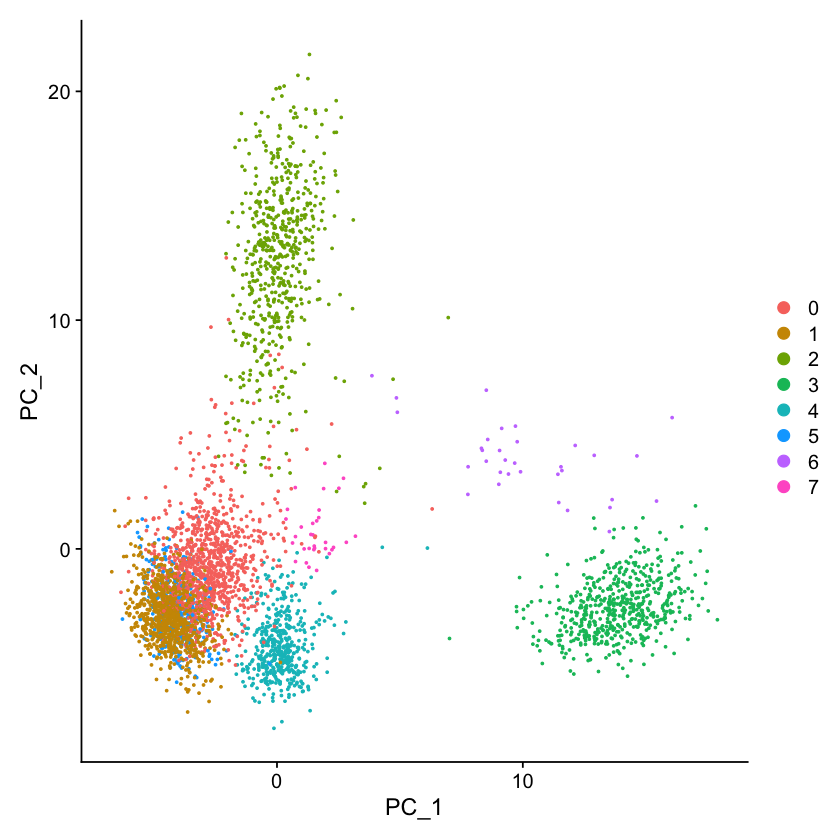

In [67]:
DimPlot(seu, reduction = "pca")

In [68]:
# calculate Adjusted Rand Index
adjustedRandIndex(Idents(seu),ID)

[1] 0.638355

## 4. Kernel PCA

In [ ]:
## Run Kernel PCA
kpca_out = kpca(t(dat@assays$RNA@scale.data),kernel="rbfdot", kpar=list(sigma=1),features = 10)
kpca_embed = kpca_out@rotated
colnames(kpca_embed) = paste0("PC_",1:ncol(kpca_embed))

seu <- CreateSeuratObject(t(kpca_embed)) #placeholder object
seu[["pca"]] <- CreateDimReducObject(as.matrix(kpca_embed),key="PC_",assay=DefaultAssay(seu))

seu <- FindNeighbors(seu, dims = 1:10)
seu <- FindClusters(seu, resolution = 0.6)

table(Idents(seu),ID)
adjustedRandIndex(Idents(seu),ID)

## 结果很差，不知道是否是核或参数选择的原因